In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [5]:
data = pd.read_csv('portfolio.csv')
data

,Date,ACB,BID,PHR,VIX
0,5/4/2020,8340,24370,34340,1730
1,5/5/2020,8340,24370,34930,1660
2,5/6/2020,8550,24850,35610,1700
3,5/7/2020,8720,25920,35840,1700
4,5/8/2020,8800,26230,35010,1700
...,...,...,...,...,...
960,3/19/2024,26850,51600,64500,19300
961,3/20/2024,27500,53000,64000,20000
962,3/21/2024,28000,53000,63900,20150
963,3/22/2024,28150,54200,64000,20150


In [6]:
def process_data(df):
    # Kiểm tra xem cột 'Date' tồn tại trong DataFrame không
    if 'Date' in df.columns:
        # Chuyển đổi cột 'Date' sang kiểu datetime
        df['Date'] = pd.to_datetime(df['Date'])
        # Đặt cột 'Date' làm chỉ số
        df.set_index('Date', inplace=True)
        # Chia các giá trị trong cột 'ACB' và 'CTG' cho 1000
        df['ACB'] /= 1000
        df['BID'] /= 1000
        df['PHR'] /= 1000
        df['VIX'] /= 1000
        return df
    else:
        print("Không tìm thấy cột 'Date' trong DataFrame.")
data = process_data(data)

<Axes: xlabel='Date'>

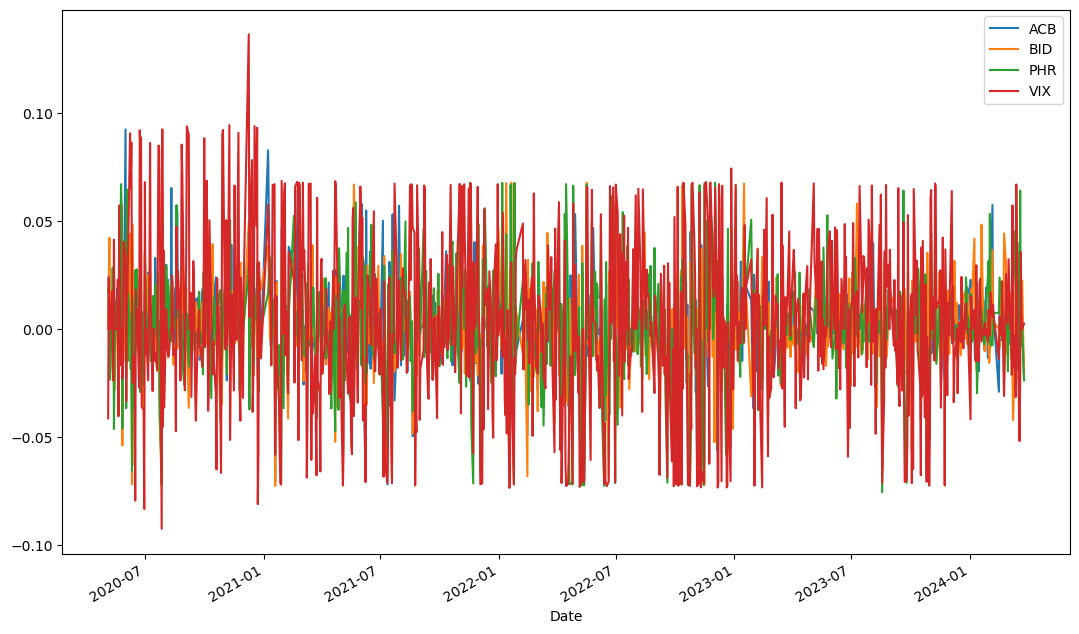

In [7]:
daily_log_returns = np.log(data) - np.log(data.shift(1))
daily_log_returns.plot(figsize=(13, 8))

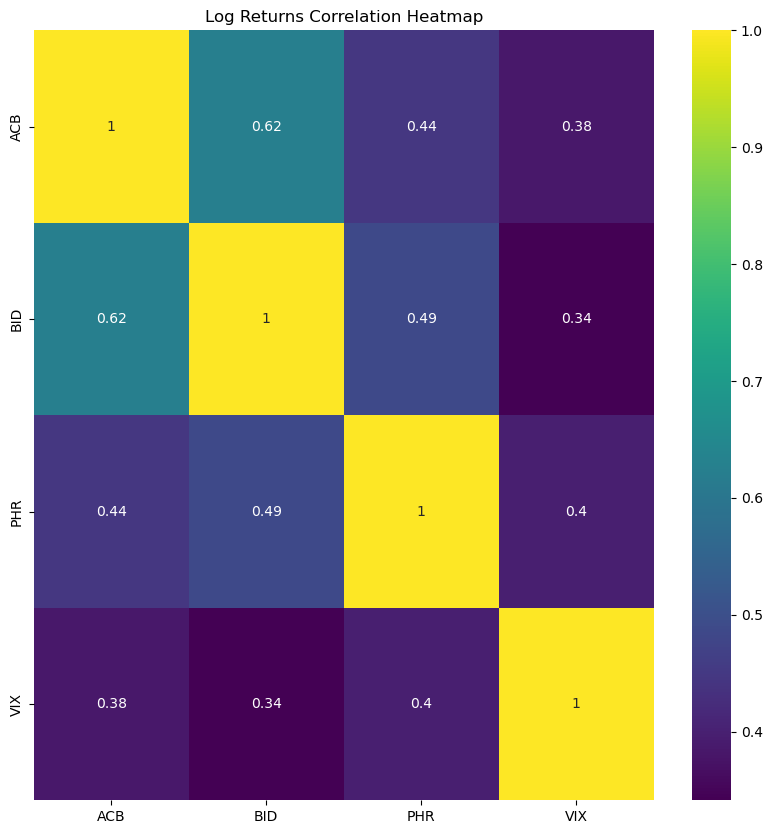

In [8]:
corr = daily_log_returns.corr()

plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, cmap="viridis")
plt.title('Log Returns Correlation Heatmap')
plt.show()

In [9]:
tickers = ['ACB', 'BID', 'PHR', 'VIX']
stocks = len(tickers)
weights = np.full((stocks,), 1 / stocks)

C:\Users\Lenovo\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


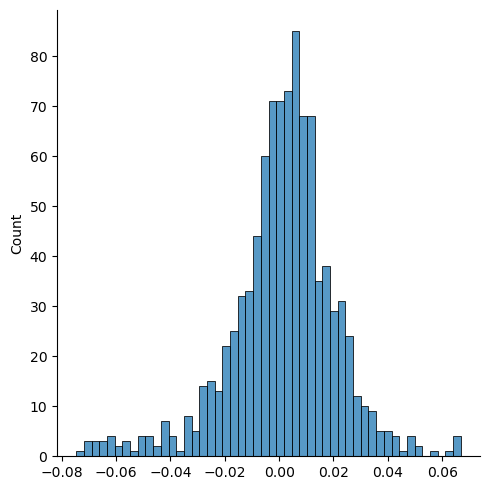

In [10]:
daily_portfolio_returns = daily_log_returns.dot(weights)
sns.displot(daily_portfolio_returns, bins=50)

In [11]:
expected_return = daily_portfolio_returns.mean() * 252
vol = daily_portfolio_returns.std() * np.sqrt(252)
skew = daily_portfolio_returns.skew()
sr = expected_return / vol

print(f"{expected_return=}")
print(f"{vol=}")
print(f"{skew=}")
print(f"{sr=}")

expected_return=0.32849394198900894
vol=0.3117324012686112
skew=-0.6266218202445076
sr=1.0537690039668184


In [12]:
returns = daily_log_returns
mean_returns = returns.mean() * 252
cov_matrix = returns.cov() * np.sqrt(252)

# Assuming 'tickers', 'mean_returns', and 'cov_matrix' are already defined
num_portfolios = 10000

# DataFrame to store the results
results = pd.DataFrame(columns=['returns', 'volatility', 'sharpe', 'weights'], index=range(num_portfolios))
# store all weights
weights_record = []

for i in range(num_portfolios):
		# Normalised randomly generated weights
    weights = np.random.random(len(tickers))
    weights /= np.sum(weights)

		# Calculate returns and volatility
    returns = np.dot(weights, mean_returns)
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

		# Store results
    results.loc[i, 'returns'] = returns
    results.loc[i, 'volatility'] = volatility
    results.loc[i, 'sharpe'] = results.loc[i, 'returns'] / results.loc[i, 'volatility']
    results.loc[i, 'weights'] = ','.join(str(np.round(weight, 4)) for weight in weights)
		# record weights
    weights_record.append(weights)
    
print(results.sort_values('sharpe', ascending=False))

       returns volatility    sharpe                      weights
8885  0.426742   0.085485   4.99199   0.5953,0.0285,0.0132,0.363
3533  0.418383    0.08382   4.99143   0.6269,0.0128,0.023,0.3372
1531  0.450858   0.090484  4.982751    0.55,0.0216,0.0006,0.4278
6539  0.416337   0.083561   4.98242  0.5995,0.0584,0.0047,0.3374
1806  0.414105    0.08317  4.978983  0.6073,0.0476,0.0137,0.3314
...        ...        ...       ...                          ...
9650  0.185227   0.087762  2.110551  0.0724,0.0866,0.8134,0.0276
206   0.183179    0.08941  2.048749   0.1053,0.019,0.8563,0.0193
7028   0.16816   0.088153  1.907592  0.0197,0.1609,0.8172,0.0022
6681  0.174251   0.091645  1.901376  0.0693,0.0204,0.8979,0.0123
2137   0.17544   0.094158  1.863254  0.0373,0.0004,0.9354,0.0269

[10000 rows x 4 columns]


In [13]:
# Efficient Frontier with max sharpe portfolio and min volatility portfolio
max_sharpe_portfolio = results.iloc[pd.to_numeric(results['sharpe']).idxmax()]
min_volatility_portfolio = results.iloc[pd.to_numeric(results['volatility']).idxmin()]

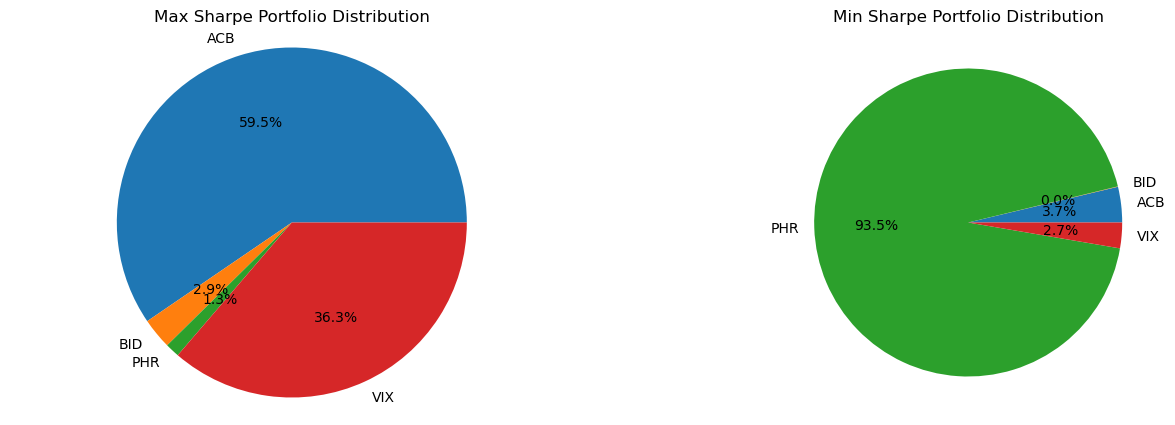

In [14]:
# Get rows with max and min 'sharpe' values
row_max = results.sort_values('sharpe', ascending=False).head(1)
row_min = results.sort_values('sharpe').head(1)

# Split the weights strings and convert to floats
weights_max = [float(x) for x in row_max['weights'].iloc[0].split(',')]
weights_min = [float(x) for x in row_min['weights'].iloc[0].split(',')]

# Creating subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 5))  # 1 row, 2 columns

# Plotting the max sharpe pie chart
axs[0].pie(weights_max, labels=tickers, autopct='%1.1f%%')
axs[0].set_title('Max Sharpe Portfolio Distribution')
axs[0].axis('equal')  # Equal aspect ratio

# Plotting the min sharpe pie chart
axs[1].pie(weights_min, labels=tickers, autopct='%1.1f%%')
axs[1].set_title('Min Sharpe Portfolio Distribution')
plt.show()

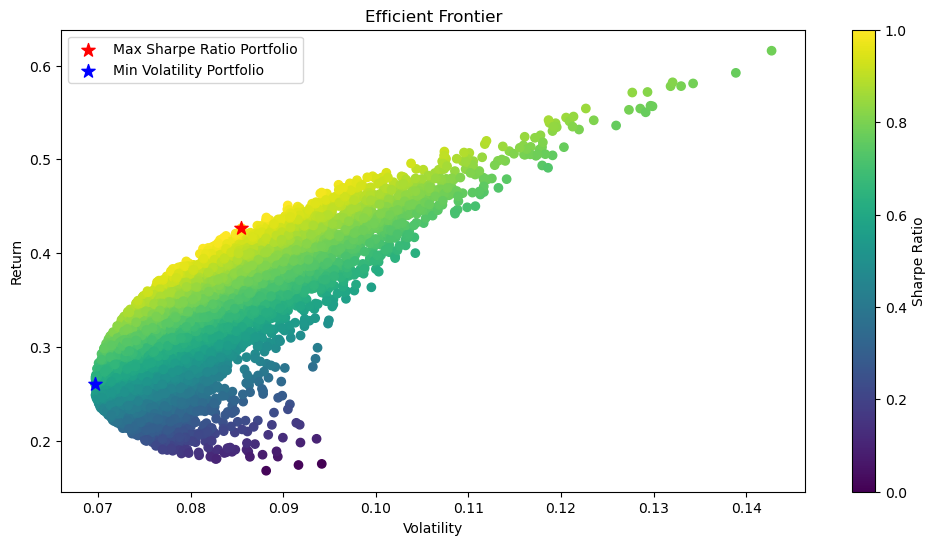

In [15]:
plt.figure(figsize=(12, 6))
plt.scatter(results['volatility'], results['returns'], c=results['sharpe'], cmap='viridis')
plt.scatter(max_sharpe_portfolio['volatility'], max_sharpe_portfolio['returns'], c='red', marker='*', s=100, label='Max Sharpe Ratio Portfolio')
plt.scatter(min_volatility_portfolio['volatility'], min_volatility_portfolio['returns'], c='blue', marker='*', s=100, label='Min Volatility Portfolio')
plt.xlabel("Volatility")
plt.ylabel("Return")
plt.title("Efficient Frontier")
plt.colorbar(label="Sharpe Ratio")
plt.legend()
plt.show()

In [16]:
# Define the span for exponential weighting
span = 60  # Adjust this based on your preference

# Calculate exponentially weighted mean returns and covariance matrix
exp_weighted_mean_returns = daily_log_returns.ewm(span=span).mean().mean() * 252
exp_weighted_cov_matrix = daily_log_returns.ewm(span=span).cov().mean() * 252

# Number of portfolios to generate
num_portfolios = 10000
results = pd.DataFrame(columns=['returns', 'volatility', 'sharpe', 'weights'], index=range(num_portfolios))

# Monte Carlo simulation with exponentially weighted parameters
for i in range(num_portfolios):
    # Normalized randomly generated weights
    weights = np.random.random(len(tickers))
    weights /= np.sum(weights)

    # Use exponentially weighted parameters
    returns = np.dot(weights, exp_weighted_mean_returns)
    volatility = np.sqrt(np.dot(weights.T, np.dot(exp_weighted_cov_matrix, weights)))

    # Store the results
    results.loc[i, 'returns'] = returns
    results.loc[i, 'volatility'] = volatility
    results.loc[i, 'sharpe'] = returns / volatility
    results.loc[i, 'weights'] = ','.join(str(np.round(weight, 4)) for weight in weights)

In [17]:
# Define a threshold (usually 0 for no gain or loss)
threshold = 0

# Calculate downside returns (returns below the threshold)
downside_returns = daily_log_returns.where(daily_log_returns < threshold, 0)

# Calculate the semicovariance matrix
semicov_matrix = downside_returns.cov() * np.sqrt(252)

# Portfolio optimisation code follows
# Use 'semicov_matrix' in place of the standard covariance matrix
# ...

# Example of Monte Carlo simulation with downside risk
num_portfolios = 10000
results = pd.DataFrame(columns=['returns', 'downside_risk', 'weights'], index=range(num_portfolios))

for i in range(num_portfolios):
    # Normalized randomly generated weights
    weights = np.random.random(len(daily_log_returns.columns))
    weights /= np.sum(weights)

    # Calculate returns and downside risk
    returns = np.dot(weights, daily_log_returns.mean() * 252)
    downside_risk = np.sqrt(np.dot(weights.T, np.dot(semicov_matrix, weights)))

In [18]:
downside_risk

0.04693747552167503

In [19]:
semicov_matrix

,ACB,BID,PHR,VIX
ACB,0.002073,0.001704,0.001653,0.001860
BID,0.001704,0.002870,0.001895,0.002081
PHR,0.001653,0.001895,0.003864,0.002858
VIX,0.001860,0.002081,0.002858,0.007277


In [20]:
returns

0.283060983761967

# 2

In [13]:
data = pd.read_csv('portfolio_1.csv')
data

,Date,ACB,VIX,MBB,GMD,HDB
0,5/4/2020,8340,1730,7230,15880,6900
1,5/5/2020,8340,1660,7210,15880,6940
2,5/6/2020,8550,1700,7280,15880,6860
3,5/7/2020,8720,1700,7430,16149,6830
4,5/8/2020,8800,1700,7570,16059,7170
...,...,...,...,...,...,...
953,3/19/2024,26850,19300,23200,77000,22350
954,3/20/2024,27500,20000,24150,78000,22600
955,3/21/2024,28000,20150,24750,78400,23900
956,3/22/2024,28150,20150,25050,78600,23800


In [14]:
def process_data(df):
    # Kiểm tra xem cột 'Date' tồn tại trong DataFrame không
    if 'Date' in df.columns:
        # Chuyển đổi cột 'Date' sang kiểu datetime
        df['Date'] = pd.to_datetime(df['Date'])
        # Đặt cột 'Date' làm chỉ số
        df.set_index('Date', inplace=True)
        # Chia các giá trị trong cột 'ACB' và 'CTG' cho 1000
        df['ACB'] /= 1000
        df['VIX'] /= 1000
        df['MBB'] /= 1000
        df['GMD'] /= 1000
        df['HDB'] /= 1000
        return df
    else:
        print("Không tìm thấy cột 'Date' trong DataFrame.")
data = process_data(data)

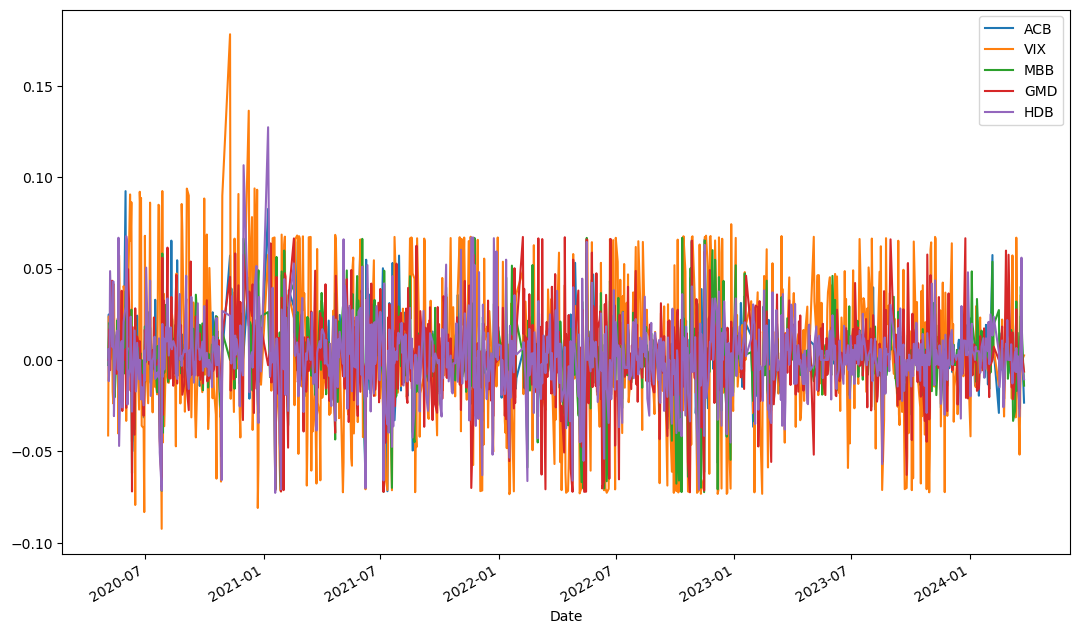

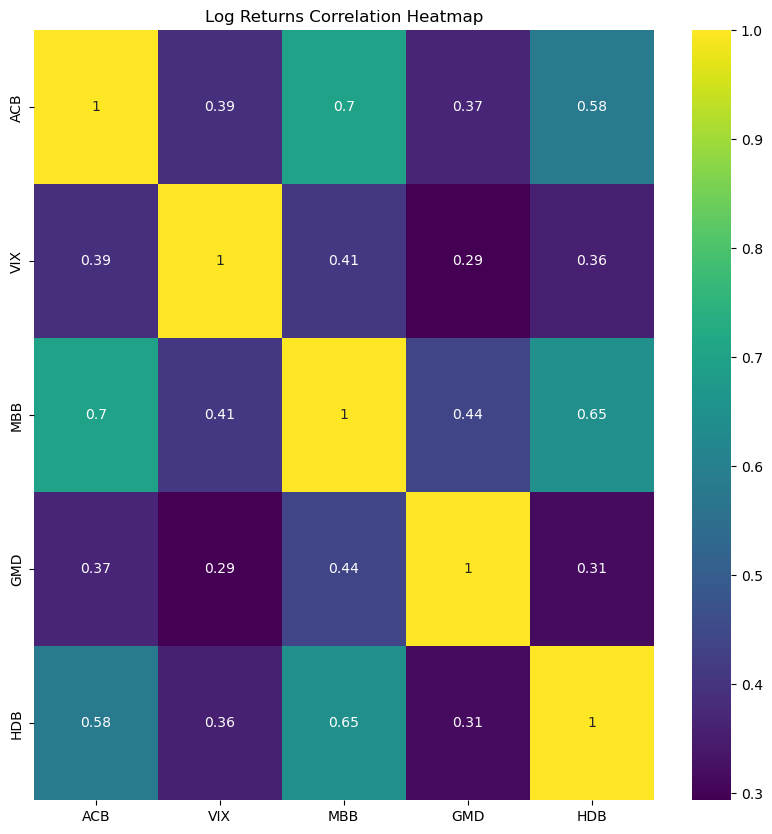

In [15]:
daily_log_returns = np.log(data) - np.log(data.shift(1))
daily_log_returns.plot(figsize=(13, 8))
corr = daily_log_returns.corr()

plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, cmap="viridis")
plt.title('Log Returns Correlation Heatmap')
plt.show()

In [16]:
tickers = ['ACB', 'VIX', 'MBB', 'GMD', 'HDB']
stocks = len(tickers)
weights = np.full((stocks,), 1 / stocks)

C:\Users\Lenovo\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


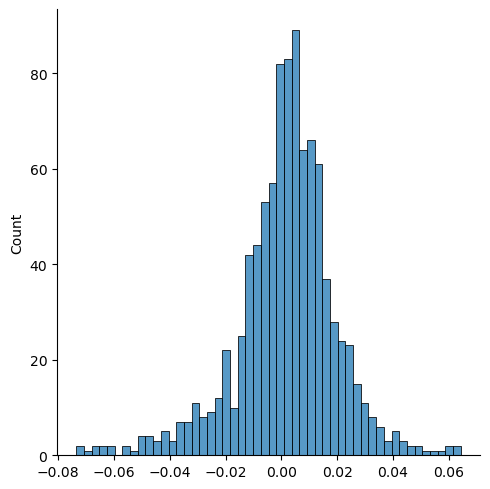

In [17]:
daily_portfolio_returns = daily_log_returns.dot(weights)
sns.displot(daily_portfolio_returns, bins=50)

In [18]:
expected_return = daily_portfolio_returns.mean() * 252
vol = daily_portfolio_returns.std() * np.sqrt(252)
skew = daily_portfolio_returns.skew()
sr = expected_return / vol

print(f"{expected_return=}")
print(f"{vol=}")
print(f"{skew=}")
print(f"{sr=}")

expected_return=0.405505771116032
vol=0.28810801753145704
skew=-0.5729321582044417
sr=1.4074782596834774


In [19]:
returns = daily_log_returns
mean_returns = returns.mean() * 252
cov_matrix = returns.cov() * np.sqrt(252)

# Assuming 'tickers', 'mean_returns', and 'cov_matrix' are already defined
num_portfolios = 10000

# DataFrame to store the results
results = pd.DataFrame(columns=['returns', 'volatility', 'sharpe', 'weights'], index=range(num_portfolios))
# store all weights
weights_record = []

for i in range(num_portfolios):
		# Normalised randomly generated weights
    weights = np.random.random(len(tickers))
    weights /= np.sum(weights)

		# Calculate returns and volatility
    returns = np.dot(weights, mean_returns)
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

		# Store results
    results.loc[i, 'returns'] = returns
    results.loc[i, 'volatility'] = volatility
    results.loc[i, 'sharpe'] = results.loc[i, 'returns'] / results.loc[i, 'volatility']
    results.loc[i, 'weights'] = ','.join(str(np.round(weight, 4)) for weight in weights)
		# record weights
    weights_record.append(weights)
    
print(results.sort_values('sharpe', ascending=False))

       returns volatility    sharpe                             weights
764    0.42516   0.073231  5.805733  0.2117,0.2137,0.0102,0.3599,0.2045
8107  0.415297   0.071583  5.801587   0.197,0.1713,0.0076,0.3985,0.2256
9860  0.422838   0.072904  5.799891  0.1918,0.1972,0.0553,0.3892,0.1666
248   0.419792   0.072391  5.798965   0.2108,0.202,0.0226,0.3433,0.2213
5306  0.419241   0.072299  5.798734   0.1913,0.1821,0.0479,0.4027,0.176
...        ...        ...       ...                                 ...
663   0.323529   0.072664  4.452374  0.1633,0.0027,0.3245,0.0082,0.5013
4828  0.328617   0.073955   4.44345   0.2686,0.0064,0.6593,0.0578,0.008
955   0.324298   0.073188  4.431036  0.1106,0.0024,0.4026,0.0122,0.4722
6279  0.322476   0.073511  4.386753  0.2861,0.0003,0.6108,0.0163,0.0866
3188  0.325802   0.074659  4.363877   0.0492,0.0044,0.5998,0.0146,0.332

[10000 rows x 4 columns]


In [20]:
# Efficient Frontier with max sharpe portfolio and min volatility portfolio
max_sharpe_portfolio = results.iloc[pd.to_numeric(results['sharpe']).idxmax()]
min_volatility_portfolio = results.iloc[pd.to_numeric(results['volatility']).idxmin()]

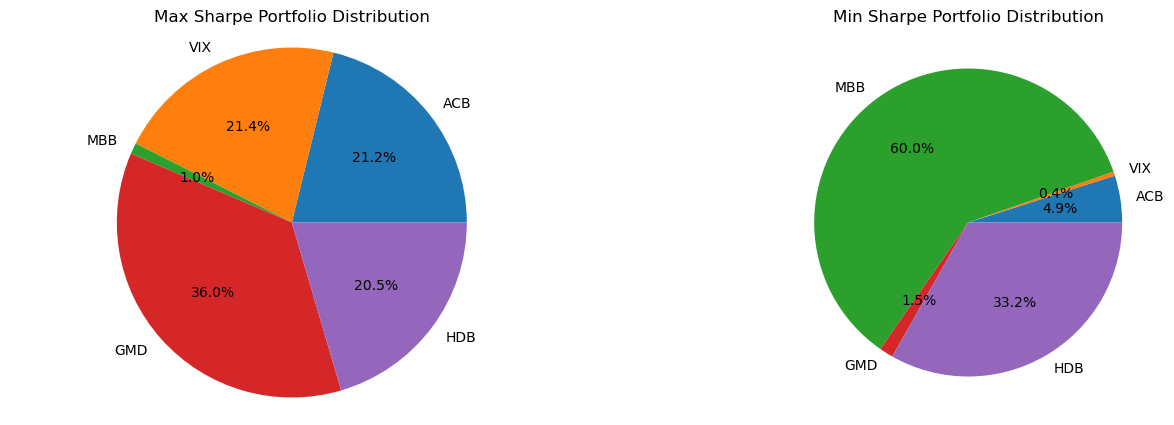

In [21]:
# Get rows with max and min 'sharpe' values
row_max = results.sort_values('sharpe', ascending=False).head(1)
row_min = results.sort_values('sharpe').head(1)

# Split the weights strings and convert to floats
weights_max = [float(x) for x in row_max['weights'].iloc[0].split(',')]
weights_min = [float(x) for x in row_min['weights'].iloc[0].split(',')]

# Creating subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 5))  # 1 row, 2 columns

# Plotting the max sharpe pie chart
axs[0].pie(weights_max, labels=tickers, autopct='%1.1f%%')
axs[0].set_title('Max Sharpe Portfolio Distribution')
axs[0].axis('equal')  # Equal aspect ratio

# Plotting the min sharpe pie chart
axs[1].pie(weights_min, labels=tickers, autopct='%1.1f%%')
axs[1].set_title('Min Sharpe Portfolio Distribution')
plt.show()